<center><font size=4 color=red> Info what use this notebook
https://www.kaggle.com/code/aliazimieco/forex-price-prediction-binary-classification-mode
https://medium.com/@dbhatt245/mastering-lstm-networks-for-text-classification-from-simple-sentiment-models-to-cnn-lstm-hybrids-00d93a131c28
https://medium.com/@jain.sm/hybrid-lstm-snn-model-for-stock-price-prediction-a-deep-dive-into-neural-network-fusion-012bd5fba7fc
https://medium.com/@moneytent/this-ai-forex-trading-strategy-will-make-you-rich-with-chat-gpt-4843132570d1
https://www.kaggle.com/code/hansmens/price-direction-prediction-eurusd-forex-pair
https://www.kaggle.com/code/muhammadqasimshabbir/lb0-9727-lgb-binaryclassificationwithbankdataset
https://capital.com/ru-int/learn/technical-analysis/fibonacci-retracement-strategy



In [85]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import ta

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            mean_absolute_error, mean_squared_error, r2_score, 
                            mean_absolute_percentage_error)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

In [86]:

ticker = 'EURUSD=X'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365) 


df = yf.download(ticker, start=start_date, end=end_date, interval='1d', progress=False)

print(f"Download data: {df.shape[0]}\n\n")
print(len(df.shape))
print("periods:", df.index.min() - df.index.max()) 

Download data: 1301


2
periods: -1823 days +00:00:00


<center><font centor size = 8 color='green'>EDA

In [87]:
df.head(5)

Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,
2020-12-22,1.223691,1.225900,1.216604,1.223840,0
2020-12-23,1.218665,1.221941,1.215776,1.218591,0
2020-12-24,1.219141,1.221747,1.217938,1.219393,0
2020-12-25,1.218472,1.221300,1.216700,1.218472,0
2020-12-28,1.220510,1.225200,1.218353,1.220703,0


In [88]:
df.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,
2025-12-15,1.173764,1.176914,1.172704,1.173750,0
2025-12-16,1.175461,1.180470,1.174605,1.175503,0
2025-12-17,1.174950,1.175793,1.170453,1.174964,0
2025-12-18,1.174233,1.175890,1.171344,1.174219,0
2025-12-19,1.172567,1.173750,1.170412,1.172539,0


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1301 entries, 2020-12-22 to 2025-12-19
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, EURUSD=X)   1301 non-null   float64
 1   (High, EURUSD=X)    1301 non-null   float64
 2   (Low, EURUSD=X)     1301 non-null   float64
 3   (Open, EURUSD=X)    1301 non-null   float64
 4   (Volume, EURUSD=X)  1301 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 61.0 KB


In [90]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
count,1301.000000,1301.000000,1301.000000,1301.000000,1301.0
mean,1.106521,1.109886,1.103051,1.106512,0.0
std,0.058330,0.057800,0.058693,0.058317,0.0
min,0.959619,0.967006,0.954016,0.959619,0.0
25%,1.069519,1.072800,1.065723,1.069519,0.0
50%,1.092777,1.095446,1.089776,1.092777,0.0
75%,1.159219,1.161211,1.155735,1.159245,0.0
max,1.234111,1.235025,1.226693,1.233776,0.0


Text(0, 0.5, 'Close')

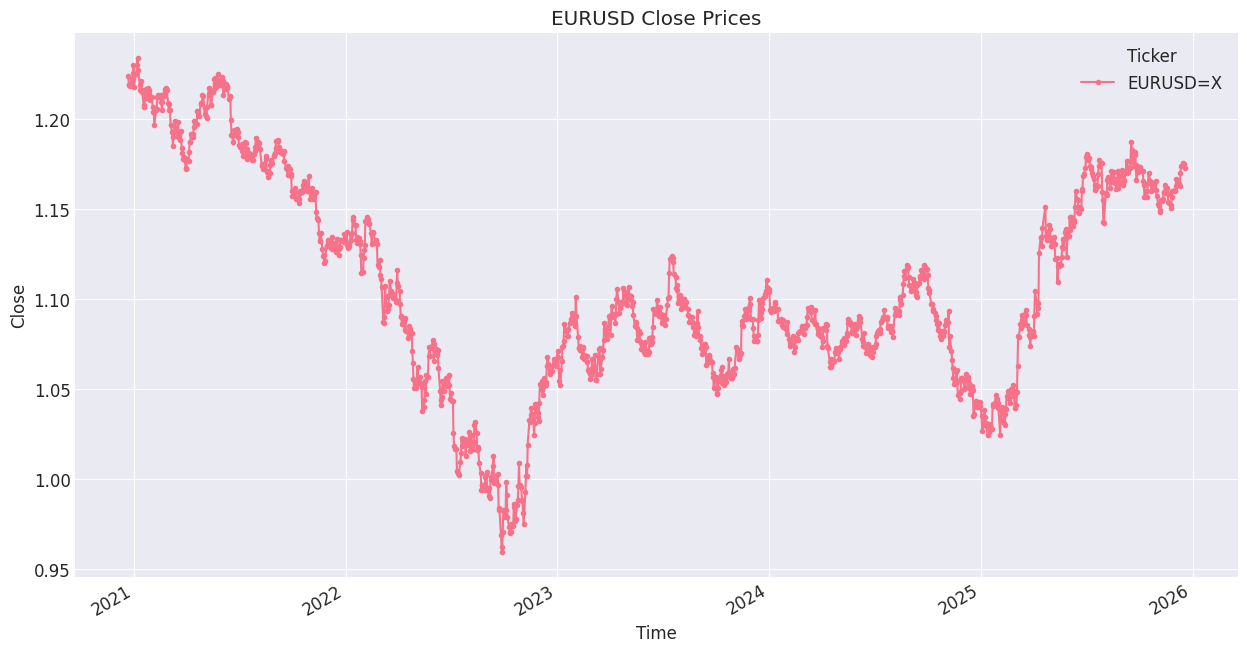

In [91]:
ax = df['Close'].plot(marker = '.', figsize= [15, 8])
ax.set_title('EURUSD Close Prices')
ax.set_xlabel("Time")
ax.set_ylabel('Close')

### Classical decomposition

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [93]:
df_trend = df['Close'].copy()
res = seasonal_decompose(x = df_trend['EURUSD=X'], model = 'additive', period=12)
res.trend.head(10)

Date
2020-12-22         NaN
2020-12-23         NaN
2020-12-24         NaN
2020-12-25         NaN
2020-12-28         NaN
2020-12-29         NaN
2020-12-30    1.223467
2020-12-31    1.224254
2021-01-01    1.224586
2021-01-04    1.224464
Name: trend, dtype: float64

In [94]:
res.seasonal.head(10)

Date
2020-12-22    0.000247
2020-12-23    0.000375
2020-12-24   -0.000373
2020-12-25   -0.000139
2020-12-28   -0.000387
2020-12-29   -0.000858
2020-12-30   -0.000503
2020-12-31   -0.000185
2021-01-01    0.000374
2021-01-04    0.000215
Name: seasonal, dtype: float64

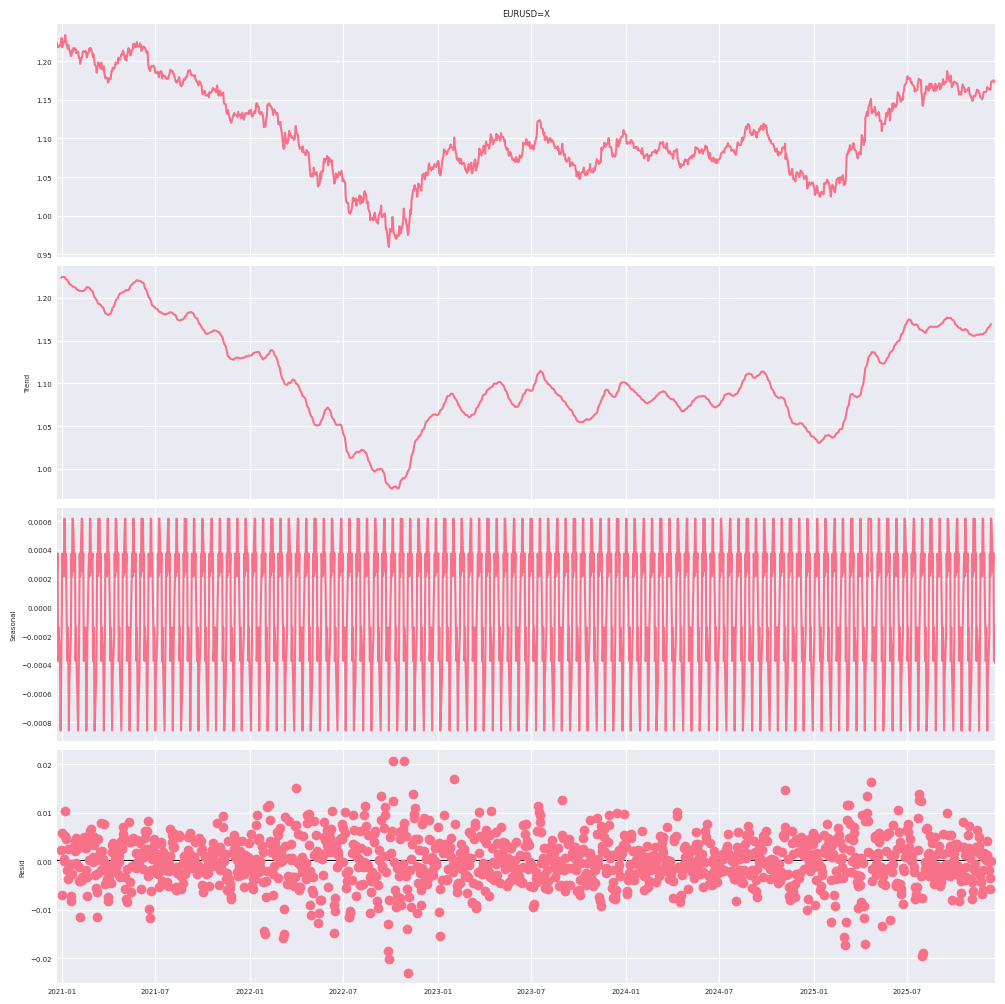

In [95]:
plt.rc("figure", figsize = (10, 10))
plt.rc("font", size = 5)
res.plot();

<font centor size = 5 color='red'>Indicators Append

In [96]:

df = df.copy()

if isinstance(df['Close'], pd.DataFrame): 
    close_series = df['Close'].squeeze()
else: 
    close_series = df['Close']

ema_periods = [8, 13, 21, 34, 55, 100]
for period in ema_periods: 
    df[f'EMA_{period}'] = close_series.ewm(span=period).mean()

print(f'Append:{len(ema_periods)} Ema indicators')


Append:6 Ema indicators


In [97]:
#fibonachi
df['High_20'] = df['High'].rolling(window=20).max()
df['Low_20'] = df['Low'].rolling(window=20).min()

fib_levels = [0.236, 0.382, 0.5, 0.628, 0.786]
for level in fib_levels:
    df[f'Fib_{level}'] = df['Low_20'] + (df['High_20'] - df['Low_20']) * level

print(f"Append {len(fib_levels)} fibonachi levels")

Append 5 fibonachi levels


In [98]:
delta = close_series.diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

exp1 = close_series.ewm(span=12).mean()
exp2 = close_series.ewm(span=26).mean()
df['MACD'] = exp1 - exp2
df['MACD_signal'] = df['MACD'].ewm(span=9).mean()
df['MACD_diff'] = df['MACD'] - df['MACD_signal']

print("Append RSI and MACD")

Append RSI and MACD


<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

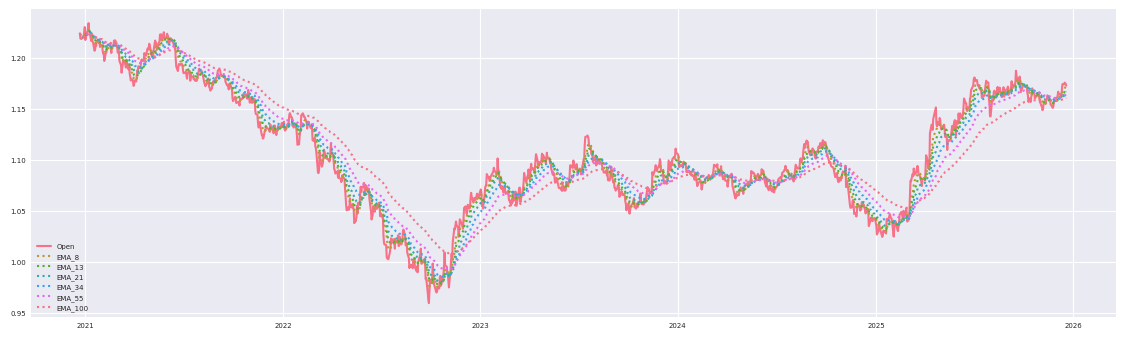

In [99]:
# Plot open price and moving averages
plt.figure(figsize=(14, 4))
plt.plot(df.index, df.Open)
plt.plot(df.index, df.EMA_8, ls=':')
plt.plot(df.index, df.EMA_13, ls=':')
plt.plot(df.index, df.EMA_21, ls=':')
plt.plot(df.index, df.EMA_34, ls=':')
plt.plot(df.index, df.EMA_55, ls=':')
plt.plot(df.index, df.EMA_100, ls=':')
plt.legend(['Open', 'EMA_8', 'EMA_13', 'EMA_21', 'EMA_34', 'EMA_55', 'EMA_100'])
plt.title

In [100]:
# 1. Расчет дневной доходности
df['Returns'] = close_series.pct_change()

# 2. Добавление временных признакоv
df['DayOfWeek'] = df.index.dayofweek
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['week'] = df.index.isocalendar().week

# 3. Создание целевых переменных на 7 дней вперед
df['Future_Price_7d'] = close_series.shift(-7) # Цена через 7 дней
df['Future_Return_7d'] = (df['Future_Price_7d'] - close_series) / close_series # Доходность за 7 дней

# 4. Классификация: разделение на 3 класса (BUY/SELL/HOLD)
# Берем 33-й и 66-й процентили доходности
percentiles = df['Future_Return_7d'].quantile([0.33, 0.66]).values

df['Target_Class'] = 0  # # HOLD (нейтральный класс) - средние 34% доходности
df.loc[df['Future_Return_7d'] < percentiles[0], 'Target_Class'] = -1  # SELL - нижние 33%
df.loc[df['Future_Return_7d'] > percentiles[1], 'Target_Class'] = 1   # BUY - верхние 66%


# 5. Регрессия: целевая цена для предсказания
df['Target_Reg'] = df['Future_Price_7d'] # Целевая цена через 7 дней


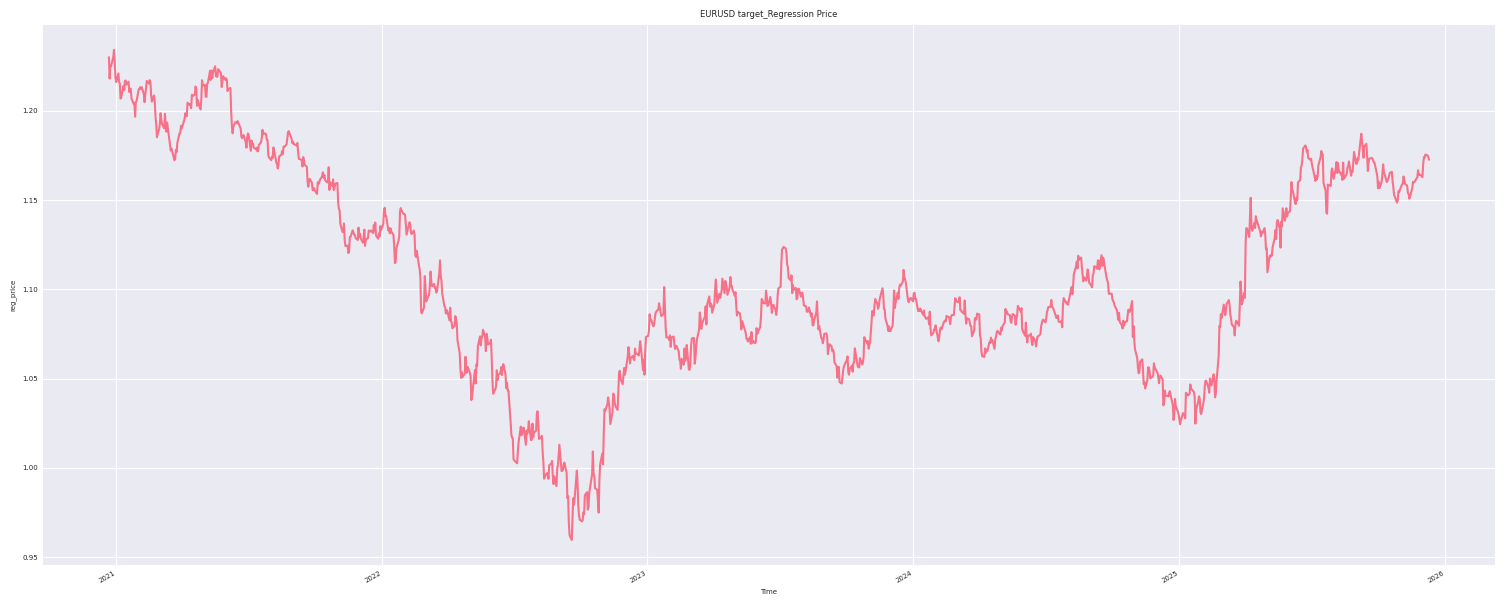

In [101]:
ax = df.plot(y = 'Target_Reg', figsize = (15, 6), legend = False)
ax.set_ylabel('reg_price')
ax.set_xlabel('Time')
ax.set_title('EURUSD target_Regression Price')
plt.tight_layout()

In [102]:
df = df.dropna()
print(f'Create: {len(df.columns)} features')

Create: 31 features


In [103]:
df.head(5)

Price,Close,High,Low,Open,Volume,EMA_8,EMA_13,EMA_21,EMA_34,EMA_55,...,MACD_diff,Returns,DayOfWeek,month,day_of_month,week,Future_Price_7d,Future_Return_7d,Target_Class,Target_Reg
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-18,1.206811,1.208620,1.205545,1.206724,0,1.216928,1.218917,1.220120,1.220777,1.221125,...,-0.001394,-0.006843,0,1,18,3,1.216299,0.007862,1,1.216299
2021-01-19,1.207729,1.214491,1.207846,1.207846,0,1.214873,1.217254,1.218818,1.219726,1.220229,...,-0.001555,0.000761,1,1,19,3,1.210507,0.002300,0,1.210507
2021-01-20,1.213887,1.216001,1.207773,1.213946,0,1.214653,1.216756,1.218307,1.219267,1.219818,...,-0.001232,0.005098,2,1,20,3,1.212004,-0.001551,0,1.212004
2021-01-21,1.211563,1.217196,1.210991,1.211534,0,1.213964,1.215992,1.217617,1.218673,1.219297,...,-0.001080,-0.001914,3,1,21,3,1.212386,0.000679,0,1.212386
2021-01-22,1.216629,1.218800,1.215200,1.216619,0,1.214558,1.216086,1.217517,1.218519,1.219134,...,-0.000636,0.004182,4,1,22,3,1.206869,-0.008022,-1,1.206869


<font centor size = 5 color='red'>Target_check

In [104]:
class_counts = df['Target_Class'].value_counts().sort_index()

for cls, count in class_counts.items(): 
    label = 'SELL' if cls == -1 else 'HOLD' if cls == 0 else 'BUY'
    print(f"{label}: {count} ({count/len(df):.1%})")

print(f" Mean: {df['Future_Return_7d'].mean():.2%}")
print(f"std: {df['Future_Return_7d']}")


SELL: 422 (33.1%)
HOLD: 418 (32.8%)
BUY: 435 (34.1%)
 Mean: -0.01%
std: Date
2021-01-18    0.007862
2021-01-19    0.002300
2021-01-20   -0.001551
2021-01-21    0.000679
2021-01-22   -0.008022
                ...   
2025-12-04    0.006068
2025-12-05    0.009603
2025-12-08    0.009388
2025-12-09    0.008666
2025-12-10    0.008372
Name: Future_Return_7d, Length: 1275, dtype: float64


The dependent variable contains  3  unique labels: [ 1  0 -1]

Percentage of "0" labels: 32.78%
Percentage of "-1" labels: 33.10%
Percentage of "1" labels: 34.12%


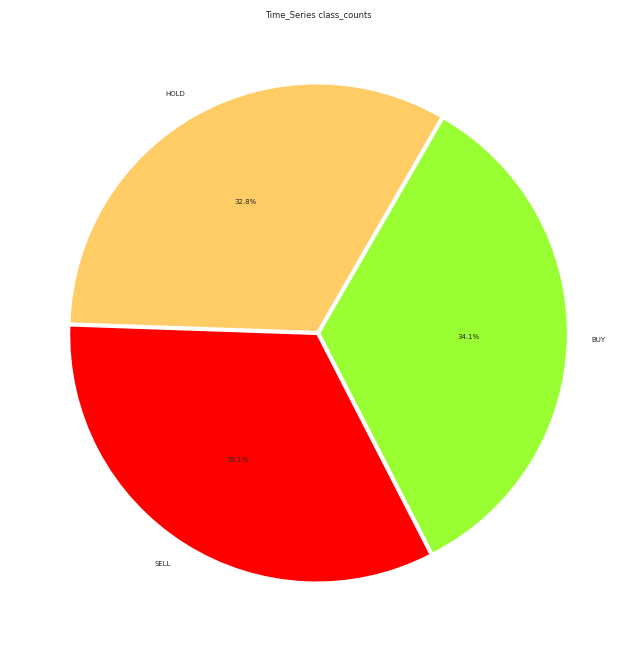

In [105]:
# multiclassification target
print('The dependent variable contains ', len(df['Target_Class'].unique()), ' unique labels:', df['Target_Class'].unique())

print('\nPercentage of "0" labels: {:.2%}'.format(list(df['Target_Class']).count(0) / len(df['Target_Class'])))
print('Percentage of "-1" labels: {:.2%}'.format(list(df['Target_Class']).count(-1) / len(df['Target_Class'])))
print('Percentage of "1" labels: {:.2%}'.format(list(df['Target_Class']).count(1) / len(df['Target_Class'])))

target = list()
target.append(list(df['Target_Class']).count(0) / len(df['Target_Class']))
target.append(list(df['Target_Class']).count(-1) / len(df['Target_Class']))
target.append(list(df['Target_Class']).count(1) / len(df['Target_Class']))

plt.figure(figsize=[12, 8])
tr_labels = ['HOLD', "SELL", "BUY"]
colors=[ '#FFCC66', 'red','#99FF33' ]
plt.pie(target, labels=tr_labels, autopct='%.1f%%', colors=colors, startangle=60, explode=[0.01]*len(tr_labels))
plt.title('Time_Series class_counts')
plt.show()

<font centor size = 5 color='yellow'>So we can see what our data is balanced

In [106]:
for variables in df: 
    print(variables, ' - number of labels: ', df[variables].nunique())
print()
print('Total number of labels: ', len(df))

('Close', 'EURUSD=X')  - number of labels:  1192
('High', 'EURUSD=X')  - number of labels:  1142
('Low', 'EURUSD=X')  - number of labels:  1211
('Open', 'EURUSD=X')  - number of labels:  1198
('Volume', 'EURUSD=X')  - number of labels:  1
('EMA_8', '')  - number of labels:  1275
('EMA_13', '')  - number of labels:  1275
('EMA_21', '')  - number of labels:  1275
('EMA_34', '')  - number of labels:  1275
('EMA_55', '')  - number of labels:  1275
('EMA_100', '')  - number of labels:  1275
('High_20', '')  - number of labels:  308
('Low_20', '')  - number of labels:  335
('Fib_0.236', '')  - number of labels:  596
('Fib_0.382', '')  - number of labels:  596
('Fib_0.5', '')  - number of labels:  596
('Fib_0.628', '')  - number of labels:  596
('Fib_0.786', '')  - number of labels:  596
('RSI', '')  - number of labels:  1275
('MACD', '')  - number of labels:  1275
('MACD_signal', '')  - number of labels:  1275
('MACD_diff', '')  - number of labels:  1275
('Returns', '')  - number of labels: 

In [107]:
# I can drop Volume because it not give me some inside
df = df.drop(['Volume'], axis=1)

In [108]:
df.head()

Price,Close,High,Low,Open,EMA_8,EMA_13,EMA_21,EMA_34,EMA_55,EMA_100,...,MACD_diff,Returns,DayOfWeek,month,day_of_month,week,Future_Price_7d,Future_Return_7d,Target_Class,Target_Reg
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-18,1.206811,1.208620,1.205545,1.206724,1.216928,1.218917,1.220120,1.220777,1.221125,1.221344,...,-0.001394,-0.006843,0,1,18,3,1.216299,0.007862,1,1.216299
2021-01-19,1.207729,1.214491,1.207846,1.207846,1.214873,1.217254,1.218818,1.219726,1.220229,1.220558,...,-0.001555,0.000761,1,1,19,3,1.210507,0.002300,0,1.210507
2021-01-20,1.213887,1.216001,1.207773,1.213946,1.214653,1.216756,1.218307,1.219267,1.219818,1.220187,...,-0.001232,0.005098,2,1,20,3,1.212004,-0.001551,0,1.212004
2021-01-21,1.211563,1.217196,1.210991,1.211534,1.213964,1.215992,1.217617,1.218673,1.219297,1.219724,...,-0.001080,-0.001914,3,1,21,3,1.212386,0.000679,0,1.212386
2021-01-22,1.216629,1.218800,1.215200,1.216619,1.214558,1.216086,1.217517,1.218519,1.219134,1.219563,...,-0.000636,0.004182,4,1,22,3,1.206869,-0.008022,-1,1.206869


<center><font centor size = 8 color='green'>7 days forward

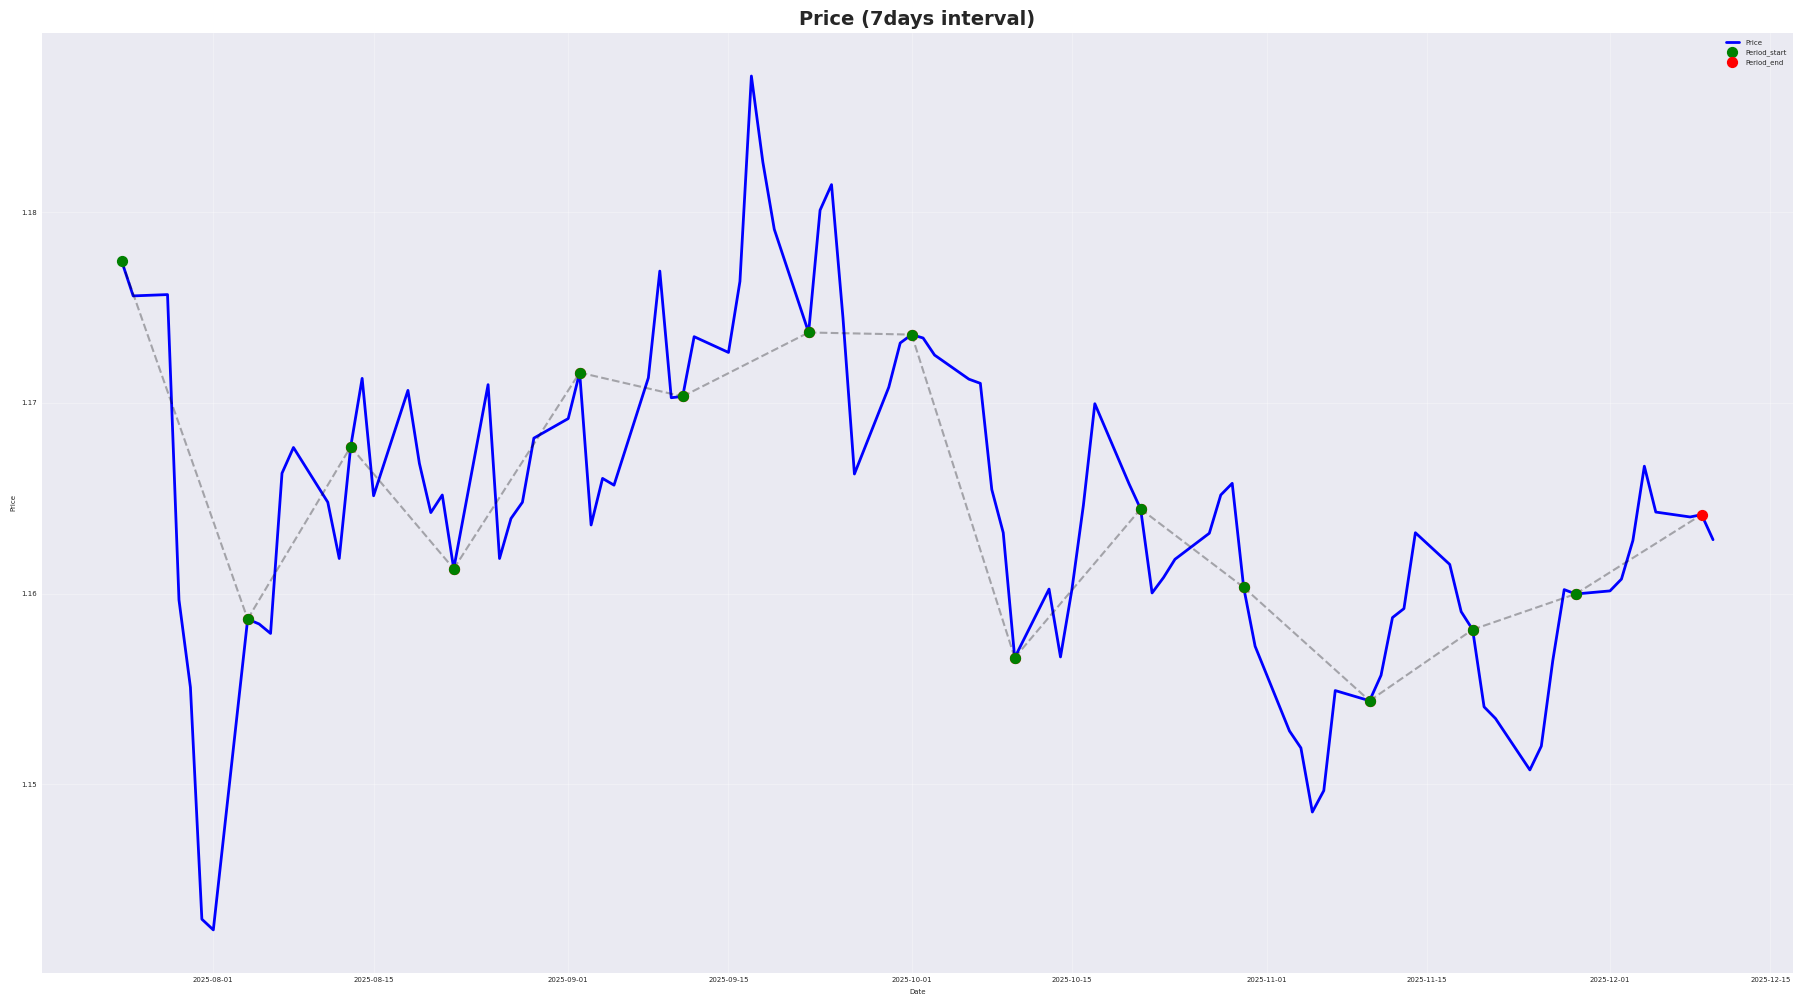

In [109]:
fig, ax = plt.subplots(figsize=(18, 10))

recent = df.tail(100)
ax.plot(
    recent.index,
    recent['Close'],
    label = 'Price', 
    linewidth=2, 
    color='blue'
    )

for i in range(0, len(recent), 7): 
    if i + 7 < len(recent): 
        ax.scatter(recent.index[i], recent['Close'].iloc[i],
                color='green', s=50, zorder=5)
        ax.scatter(recent.index[i+7], recent['Close'].iloc[i+7], 
                color='red', s=50, zorder=5)
        ax.plot([recent.index[i], recent.index[i+7]], 
                [recent['Close'].iloc[i], recent['Close'].iloc[i+7]], 
                'k--', alpha=0.3)
ax.set_title('Price (7days interval)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(['Price', 'Period_start', 'Period_end'])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<center><font centor size = 8 color='green'>7-day returns

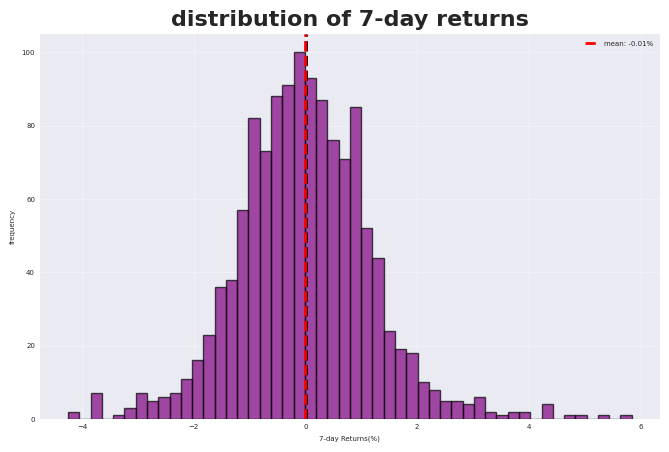

In [110]:
# Средняя доходность на 7 дней
fig, ax = plt.subplots(figsize=[8, 5])
ax.hist(df['Future_Return_7d'] * 100, bins=50, alpha=0.7, 
        color='purple', edgecolor='black')

ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax.axvline(x=df['Future_Return_7d'].mean() * 100,
        color='red', 
        linestyle='--', 
        linewidth=2,
        label=f'mean: {df["Future_Return_7d"].mean()*100:.2f}%')
ax.set_title('distribution of 7-day returns',
        fontsize=16, 
        fontweight='bold')
ax.set_xlabel('7-day Returns(%)')
ax.set_ylabel('frequency')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


<font color='green' size=3>Гистограмма (фиолетовые столбцы) - показывает, как часто встречаются разные значения доходности
Черная пунктирная линия - уровень нулевой доходности

Красная пунктирная линия - среднее значение доходности за 7 дней

Если столбцы справа от нуля - положительные доходности (цена выросла)

Если столбцы слева от нуля - отрицательные доходности (цена упала)

Высота столбцов - сколько раз встречалась такая доходность

Положение красной линии - средняя доходность за весь период



<center><font center size = 5 color='red'>

In [111]:
print("Статистика 7-дневной доходности:")
print(f"mean: {df['Future_Return_7d'].mean()*100:.2f}%")
print(f"Median: {df['Future_Return_7d'].median()*100:.2f}%")
print(f"Std: {df['Future_Return_7d'].std()*100:.2f}%")
print(f"Min: {df['Future_Return_7d'].min()*100:.2f}%")
print(f"Max: {df['Future_Return_7d'].max()*100:.2f}%")

# Процент положительных доходностей
positive_returns = (df['Future_Return_7d'] > 0).sum() / len(df) * 100
print(f"Positive returns procent: {positive_returns:.1f}%")

Статистика 7-дневной доходности:
mean: -0.01%
Median: -0.04%
Std: 1.21%
Min: -4.25%
Max: 5.84%
Positive returns procent: 48.0%


<center><font center size=5 color='red'>Class counts

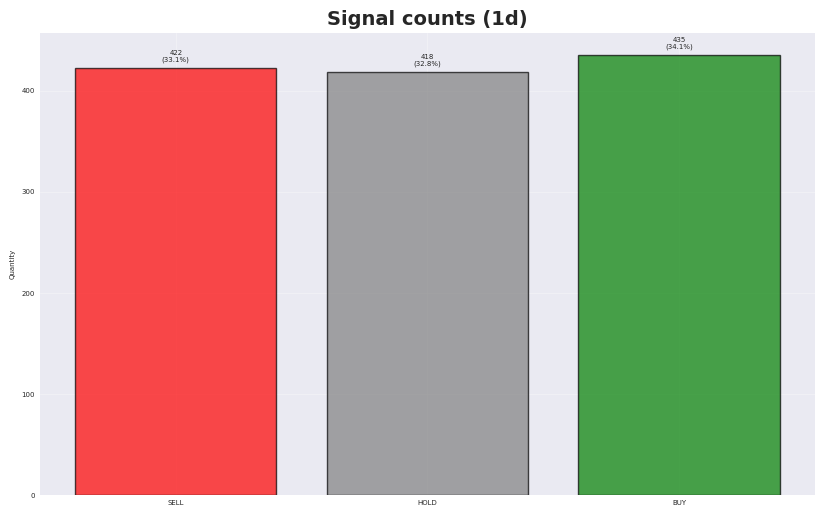

In [112]:
fig, ax = plt.subplots(figsize=[10, 6])

clas_counts = df['Target_Class'].value_counts().sort_index()
colors = ['red', 'gray', 'green']
labels = ['SELL', 'HOLD', 'BUY']

bars = ax.bar(labels, class_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Signal counts (1d)', fontsize=14, fontweight='bold')
ax.set_ylabel('Quantity')

for bar, count in zip(bars, class_counts.values): 
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5, 
            f'{count}\n({count/len(df):.1%})', 
            ha='center', va='bottom')
ax.grid(True, alpha=0.3)
plt.show()

<font center size=6 color="red">Features Correlation 

<Axes: xlabel='Price-Ticker', ylabel='Price-Ticker'>

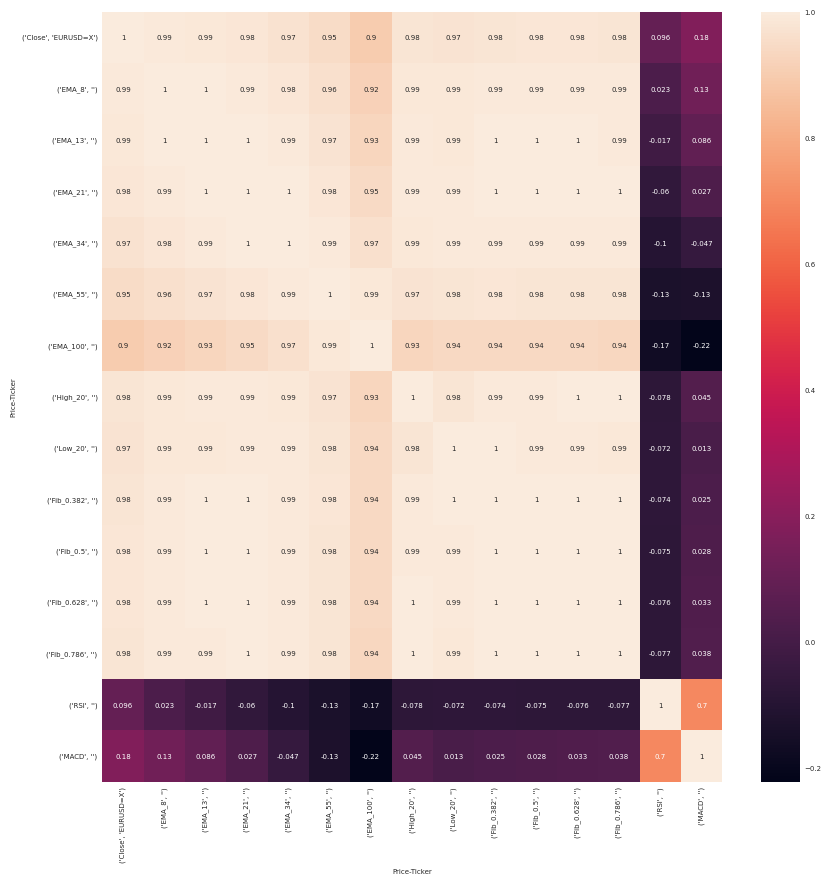

In [113]:
corr_features = ['Close', 'EMA_8', 'EMA_13', 
                'EMA_21', 'EMA_34', 'EMA_55', 
                'EMA_100', 'High_20', 'Low_20',
                'Fib_0.382', 'Fib_0.5', 'Fib_0.628', 
                'Fib_0.786', 'RSI', 'MACD']
corr = df[corr_features].corr()

sns.heatmap( 
    corr, 
    annot= True, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

<center><font center size=6 color='red'> Model Prepare

In [114]:
def prepare_model_data_7day(df, seq_length=30):

    feature_cols = [
      'Close', 'EMA_8', 'EMA_13', 'EMA_21', 
      'EMA_34', 'EMA_55', 'EMA_100', 
      'MACD_signal',	'MACD_diff',	'Returns',	
      'DayOfWeek',	'Month',	'WeekOfYear', 
      'Future_Price_7d',	'Future_Return_7d',
      'RSI', 'MACD', 'High_20', 'Low_20', 
      'Fib_0.236', 'Fib_0.382', 'Fib_0.5', 
      'Fib_0.628', 'Fib_0.786' 
    ]

    available_cols = [col for col in feature_cols if col in df.columns]
    print('use ', len(available_cols), ' features')

    X = df[available_cols].values
    y_class = df['Target_Class'].values + 1 # Change -1,0,1 to 0,1,2
    y_reg = df['Target_Reg'].values #Price then 7-day

    print('Size X: ', X.shape)
    print('Size y_class: ', y_class.shape)
    print('Size y_reg: ', y_reg.shape)

    # TimeSeries think train/test split
    split_idx = int(len(X) * 0.8)

    X_train = X[:split_idx]
    X_test = X[split_idx:]

    y_class_train = y_class[:split_idx]
    y_class_test = y_class[split_idx:]

    y_reg_train = y_reg[:split_idx]
    y_reg_test = y_reg[split_idx:]

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.fit_transform(X_test)

    scaler_y = StandardScaler()
    y_reg_train_scaled = scaler_y.fit_transform(y_reg_train.reshape(-1, 1)).flatten()
    y_reg_test_scaled = scaler_y.transform(y_reg_test.reshape(-1, 1)).flatten()


    #For lstm 
    X_train_seq, y_class_train_seq, y_reg_train_seq = [], [], []
    X_test_seq, y_class_test_seq, y_reg_test_seq = [], [], []

    scaler_lstm_X = MinMaxScaler()
    scaler_lstm_y = MinMaxScaler()

    X_scaled_all = scaler_lstm_X.fit_transform(X)
    y_reg_scaled_all = scaler_lstm_y.fit_transform(y_reg.reshape(-1, 1)).flatten()

    for i in range(seq_length, split_idx): 
      X_train_seq.append(X_scaled_all[i-seq_length:i])
      y_class_train_seq.append(y_class[i])
      y_reg_train_seq.append(y_reg_scaled_all[i])

    for i in range(split_idx + seq_length, len(X_scaled_all)): 
      X_test_seq.append(X_scaled_all[i-seq_length:i])
      y_class_test_seq.append(y_class[i])
      y_reg_test_seq.append(y_reg_scaled_all[i])

    X_train_seq = np.array(X_train_seq)
    X_test_seq = np.array(X_test_seq)

    y_class_train_seq = np.array(y_class_train_seq)
    y_class_test_seq = np.array(y_class_test_seq)

    y_reg_train_seq = np.array(y_reg_train_seq)
    y_reg_test_seq = np.array(y_reg_test_seq)

    print("Sizes for LSTM: ")
    print("X_train_seq: ", X_train_seq.shape)
    print('X_test_seq: ', X_test_seq.shape)

    return {
    # Для традиционных моделей
    'X_train': X_train_scaled, 'X_test': X_test_scaled,
    'y_class_train': y_class_train, 'y_class_test': y_class_test,
    'y_reg_train': y_reg_train_scaled, 'y_reg_test': y_reg_test_scaled,
    'y_reg_original_train': y_reg_train, 'y_reg_original_test': y_reg_test,

    # Для LSTM
    'X_train_seq': X_train_seq, 'X_test_seq': X_test_seq,
    'y_class_train_seq': y_class_train_seq, 'y_class_test_seq': y_class_test_seq,
    'y_reg_train_seq': y_reg_train_seq, 'y_reg_test_seq': y_reg_test_seq,

    # Скалеры
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'scaler_lstm_X': scaler_lstm_X,
    'scaler_lstm_y': scaler_lstm_y,

    'feature_cols': available_cols,
    'seq_length': seq_length
    }

In [115]:
df_dict = prepare_model_data_7day(df, seq_length=30)

use  22  features
Size X:  (1275, 22)
Size y_class:  (1275,)
Size y_reg:  (1275,)
Sizes for LSTM: 
X_train_seq:  (990, 30, 22)
X_test_seq:  (225, 30, 22)


<center><font center size=6 color='red'> Models training

In [116]:
models = {}
results = {}
metrics = {}

<center><font center size=6 color='green'> Rf_classification

In [124]:
randomforest_classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state=0)
randomforest_classifier.fit(df_dict['X_train'], df_dict['y_class_train'])

#GridSearch
parameters = [
    {
        'criterion' : ['gini','entropy','log_loss'],
        'n_estimators':[100, 200, 500],
        'max_depth': [5, 6, 10]
     }
]

grid_search = GridSearchCV(
    estimator = randomforest_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(df_dict['X_train'], df_dict['y_class_train'])
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}


In [127]:
#RF classific. 
rf_classifier = RandomForestClassifier( 
    n_estimators = 200,
    criterion='gini',  
    max_depth = 10, 
    random_state = 42, 
    n_jobs=-1
)

rf_classifier.fit(df_dict["X_train"], df_dict['y_class_train'])
y_pred = rf_classifier.predict(df_dict['X_test'])
accuracy = accuracy_score(df_dict['y_class_test'], y_pred)
report_dict = classification_report(df_dict['y_class_test'], y_pred, output_dict=True, 
zero_division=0)
metrics['rf_class_report'] = report_dict


models['random_forest'] = rf_classifier
results['random_forest'] = { 
    'accuracy': accuracy, 
    'predictions': y_pred, 
    'model': rf_classifier,
    'metrics': metrics['rf_class_report']
}
print(f"Accuracy: {accuracy:.3f}\n")
metrics['rf_class_report']

Accuracy: 0.718



{'0': {'precision': 0.6989247311827957,
  'recall': 1.0,
  'f1-score': 0.8227848101265823,
  'support': 65.0},
 '1': {'precision': 0.5319148936170213,
  'recall': 0.6410256410256411,
  'f1-score': 0.5813953488372093,
  'support': 78.0},
 '2': {'precision': 1.0,
  'recall': 0.6071428571428571,
  'f1-score': 0.7555555555555554,
  'support': 112.0},
 'accuracy': 0.7176470588235294,
 'macro avg': {'precision': 0.7436132082666056,
  'recall': 0.7493894993894994,
  'f1-score': 0.7199119048397824,
  'support': 255.0},
 'weighted avg': {'precision': 0.7800763499176839,
  'recall': 0.7176470588235294,
  'f1-score': 0.7194198905480486,
  'support': 255.0}}

<center><font center size=6 color='green'> xgboost classification

In [119]:
#Xgboost 
xgb_classifier = xgb.XGBClassifier( 
    n_estimators = 100, 
    max_depth = 6, 
    learning_rate=0.1, 
    random_state=42, 
    n_jobs=-1
)
xgb_classifier.fit(df_dict['X_train'], df_dict['y_class_train'])

y_pred = xgb_classifier.predict(df_dict['X_test'])
accuracy = accuracy_score(df_dict['y_class_test'], y_pred)
report_dict = classification_report(df_dict['y_class_test'], y_pred, output_dict=True, 
zero_division=0)
metrics['xgb_class'] = report_dict


models['xgboost'] = xgb_classifier 
results['xgboost'] = { 
    'accuracy': accuracy, 
    'predictions': y_pred, 
    'model': xgb_classifier, 
    'metrics': metrics['xgb_class']
}

print(f'Accuracy: {accuracy:.3f}')
metrics['xgb_class']

Accuracy: 0.722


{'0': {'precision': 0.6914893617021277,
  'recall': 1.0,
  'f1-score': 0.8176100628930818,
  'support': 65.0},
 '1': {'precision': 0.5384615384615384,
  'recall': 0.6282051282051282,
  'f1-score': 0.5798816568047337,
  'support': 78.0},
 '2': {'precision': 1.0,
  'recall': 0.625,
  'f1-score': 0.7692307692307693,
  'support': 112.0},
 'accuracy': 0.7215686274509804,
 'macro avg': {'precision': 0.7433169667212219,
  'recall': 0.7510683760683761,
  'f1-score': 0.7222408296428616,
  'support': 255.0},
 'weighted avg': {'precision': 0.7801835627868169,
  'recall': 0.7215686274509804,
  'f1-score': 0.7236441940104538,
  'support': 255.0}}

<center><font center size=6 color='green'> lgbm classification

In [120]:
#lightGBM
lgb_class = lgb.LGBMClassifier( 
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1,
    random_state=42, 
    n_jobs=-1, 
)
lgb_class.fit(df_dict['X_train'], df_dict['y_class_train'])
y_pred = lgb_class.predict(df_dict['X_test'])
accuracy = accuracy_score(df_dict['y_class_test'], y_pred)
report_dict = classification_report(df_dict['y_class_test'], y_pred, output_dict=True, 
zero_division=0)
metrics['lgb_class'] = report_dict

models['lightgbm'] = lgb_class
results['lightgbm'] = { 
    'accuracy': accuracy, 
    'prediction': y_pred, 
    'model': lgb_class,
    'metrics': metrics['lgb_class']
}

print(f'Accuracy: {accuracy:.3f}')
metrics['lgb_class']


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5226
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 22
[LightGBM] [Info] Start training from score -1.049822
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.149906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

{'0': {'precision': 0.6989247311827957,
  'recall': 1.0,
  'f1-score': 0.8227848101265823,
  'support': 65.0},
 '1': {'precision': 0.5319148936170213,
  'recall': 0.6410256410256411,
  'f1-score': 0.5813953488372093,
  'support': 78.0},
 '2': {'precision': 1.0,
  'recall': 0.6071428571428571,
  'f1-score': 0.7555555555555554,
  'support': 112.0},
 'accuracy': 0.7176470588235294,
 'macro avg': {'precision': 0.7436132082666056,
  'recall': 0.7493894993894994,
  'f1-score': 0.7199119048397824,
  'support': 255.0},
 'weighted avg': {'precision': 0.7800763499176839,
  'recall': 0.7176470588235294,
  'f1-score': 0.7194198905480486,
  'support': 255.0}}

<center><font center size=6 color='green'> SVC classification

In [133]:
svc_classifier = SVC(kernel = 'linear', probability = True, random_state=0)
svc_classifier.fit(df_dict['X_train'], df_dict['y_class_train'])

#GridSearch
parameters = [
    {
        'C':[1, 5, 6],
        'kernel':['linear', 'rbf']
     }
]

grid_search = GridSearchCV(
    estimator = svc_classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(df_dict['X_train'], df_dict['y_class_train'])
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'C': 5, 'kernel': 'linear'}


In [141]:
svc = SVC( 
    C=1, 
    kernel='rbf', 
    probability=True, 
    random_state=42
)
svc.fit(df_dict['X_train'], df_dict['y_class_train'])

y_pred = svc.predict(df_dict['X_test'])
accuracy = accuracy_score(df_dict['y_class_test'], y_pred)
report_dict = classification_report(df_dict['y_class_test'], y_pred, output_dict=True, 
zero_division=0)
metrics['svc'] = report_dict

models['svc'] = svc
results['svc'] = { 
    'accuracy': accuracy, 
    'predictions': y_pred, 
    'model': svc,
    'metrics': metrics['svc']
}

print(f'Accuracy: {accuracy:.3f}')
metrics['svc']

Accuracy: 0.737


{'0': {'precision': 0.7804878048780488,
  'recall': 0.9846153846153847,
  'f1-score': 0.870748299319728,
  'support': 65.0},
 '1': {'precision': 0.5504587155963303,
  'recall': 0.7692307692307693,
  'f1-score': 0.641711229946524,
  'support': 78.0},
 '2': {'precision': 1.0,
  'recall': 0.5714285714285714,
  'f1-score': 0.7272727272727273,
  'support': 112.0},
 'accuracy': 0.7372549019607844,
 'macro avg': {'precision': 0.7769821734914597,
  'recall': 0.775091575091575,
  'f1-score': 0.7465774188463264,
  'support': 255.0},
 'weighted avg': {'precision': 0.8065391652297528,
  'recall': 0.7372549019607844,
  'f1-score': 0.7376731797888496,
  'support': 255.0}}

In [142]:
# Choice best model 
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = models[best_model_name]
best_accuracy = results[best_model_name]['accuracy']

print(f"best model: {best_model_name}")
print(f'best Accuracy: {best_accuracy:.3f}')

best model: svc
best Accuracy: 0.737


<center><font center size=6 color='red'> Regression Models

In [143]:
models = {}
results = {}


<center><font center size=6 color='green'> Rf_regression

In [145]:
rf_regressor = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
rf_regressor.fit(df_dict['X_train'], df_dict['y_reg_train'])

y_pred_scaled = rf_regressor.predict(df_dict['X_test'])
y_pred = df_dict['scaler_y'].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

mae = mean_absolute_error(df_dict['y_reg_original_test'], y_pred)
r2 = r2_score(df_dict['y_reg_original_test'], y_pred)
mape = mean_absolute_percentage_error(df_dict['y_reg_original_test'], y_pred) * 100

models['random_forest'] = rf_regressor
results['random_forest'] = {
    'mae': mae,
    'r2': r2,
    'mape': mape,
    'predictions': y_pred,
    'model': rf_regressor
}
print(f"  MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

  MAE: 0.0292, R²: 0.6474, MAPE: 2.62%


<center><font center size=6 color='green'> XGB_regression

In [146]:
xgb_regressor = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
xgb_regressor.fit(df_dict['X_train'], df_dict['y_reg_train'])

y_pred_scaled = xgb_regressor.predict(df_dict['X_test'])
y_pred = df_dict['scaler_y'].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

mae = mean_absolute_error(df_dict['y_reg_original_test'], y_pred)
r2 = r2_score(df_dict['y_reg_original_test'], y_pred)
mape = mean_absolute_percentage_error(df_dict['y_reg_original_test'], y_pred) * 100

models['xgboost'] = xgb_regressor
results['xgboost'] = {
    'mae': mae,
    'r2': r2,
    'mape': mape,
    'predictions': y_pred,
    'model': xgb_regressor
}
print(f"  MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

  MAE: 0.0292, R²: 0.6482, MAPE: 2.62%


<center><font center size=6 color='green'> LGBM_regression

In [147]:
lgb_regressor = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
lgb_regressor.fit(df_dict['X_train'], df_dict['y_reg_train'])

y_pred_scaled = lgb_regressor.predict(df_dict['X_test'])
y_pred = df_dict['scaler_y'].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

mae = mean_absolute_error(df_dict['y_reg_original_test'], y_pred)
r2 = r2_score(df_dict['y_reg_original_test'], y_pred)
mape = mean_absolute_percentage_error(df_dict['y_reg_original_test'], y_pred) * 100

models['lightgbm'] = lgb_regressor
results['lightgbm'] = {
    'mae': mae,
    'r2': r2,
    'mape': mape,
    'predictions': y_pred,
    'model': lgb_regressor
}
print(f"  MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5226
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 22
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

<center><font center size=6 color='green'> SVR_regression

In [ ]:
svr = SVR(
    C=1.0,
    kernel='rbf'
)
svr.fit(df_dict['X_train'], df_dict['y_reg_train'])

y_pred_scaled = svr.predict(df_dict['X_test'])
y_pred = df_dict['scaler_y'].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

mae = mean_absolute_error(df_dict['y_reg_original_test'], y_pred)
r2 = r2_score(df_dict['y_reg_original_test'], y_pred)
mape = mean_absolute_percentage_error(df_dict['y_reg_original_test'], y_pred) * 100

models['svr'] = svr
results['svr'] = {
    'mae': mae,
    'r2': r2,
    'mape': mape,
    'predictions': y_pred,
    'model': svr
}
print(f"  MAE: {mae:.4f}, r2: {r2:.4f}, MAPE: {mape:.2f}%")
    

  MAE: 0.0321, R²: 0.5737, MAPE: 2.87%


In [155]:
best_model_name = min(results.items(), key=lambda x: x[1]['mae'])[0]
best_model = models[best_model_name]
best_mae = results[best_model_name]['mae']
best_r2 = results[best_model_name]['r2']
best_mape = results[best_model_name]['mape']

print(f"\nBest regression model: {best_model_name}\n")
print(f"MAE: {best_mae:.4f}, R2: {best_r2:.4f},  MAPE: {best_mape:.4f}")


Best regression model: lightgbm

MAE: 0.0286, R2: 0.6609,  MAPE: 2.5655


<center><font center size=6 color='green'> LSTM model

In [156]:
def create_lstm_regression_model(input_shape):
    """Создание LSTM модели для регрессии на 7 дней"""
    
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')  # Прогноз цены
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mape',
        metrics=['mae', 'mse', 'mape']
    )
    
    model.summary()
    return model
